In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import air_traff_utils as atu
from sklearn import preprocessing

import ipdb

In [35]:
atu.setup_seed(12)

# Loading Data

In [38]:
us_CSA = pd.read_csv('./data/us_CSA.csv')
OD = pd.read_csv('./outputs/201904_OD_CSA.csv', index_col=0).sort_index(axis=0).sort_index(axis=1)
CSA_df = pd.read_csv('./data/CSA_df.csv')

In [39]:
us_CSA_use = us_CSA.loc[us_CSA['if_plot']==1]
print(us_CSA_use.shape)
us_CSA_use.head(2)

(24, 27)


,Unnamed: 0,TotPop,CSA,CBSA,CBSA_Name,AutoOwn0,AutoOwn1,AutoOwn2p,TotEmp,E_LowWageW,...,D4C,D4D,D5AR,D5AE,NatWalkInd,INTPTLAT,INTPTLON,CSA_Name,if_plot,geometry
6,6,6584708,122.0,29300.0,"LaGrange, GA-AL",142257,759558,1449909,2970375,668868,...,-60276.863137,-60268.179268,310871248,224466891,8.498581,33.834001,-84.305803,"Atlanta--Athens-Clarke County--Sandy Springs, ...",1,"POLYGON ((-85.165852 32.808496999999996, -85.1..."
13,13,8200935,148.0,49340.0,"Worcester, MA-CT",349774,1079810,1704849,3823517,825804,...,-28799.664050,-28642.284283,646668796,596458073,11.342761,42.293282,-71.237945,"Boston-Worcester-Providence, MA-RI-NH-CT",1,"MULTIPOLYGON (((-71.883921 41.326498, -71.8821..."


In [40]:
data_X = pd.DataFrame(us_CSA_use.copy().drop(['CSA', 'CBSA', 'CBSA_Name', 'INTPTLAT', 'INTPTLON', 'geometry', 'if_plot'], axis=1))
data_X.index = range(data_X.shape[0])


In [41]:
data_X['CSA_Code'] = ''
for i in data_X.index:
    CSA_Name = data_X.loc[i, 'CSA_Name']
    data_X.loc[i, 'CSA_Code'] = CSA_df.loc[CSA_df['CSA_Name']==CSA_Name, 'Airport'].values[0]

print(data_X.shape)
data_X.head(2)

(24, 21)


,Unnamed: 0,TotPop,AutoOwn0,AutoOwn1,AutoOwn2p,TotEmp,E_LowWageW,E_MedWageW,E_HiWageWk,D1B,...,D3A,D4A,D4B050,D4C,D4D,D5AR,D5AE,NatWalkInd,CSA_Name,CSA_Code
0,6,6584708,142257,759558,1449909,2970375,668868,969644,1331863,4.184264,...,11.808044,-67955.508346,0.026778,-60276.863137,-60268.179268,310871248,224466891,8.498581,"Atlanta--Athens-Clarke County--Sandy Springs, ...",ATL
1,13,8200935,349774,1079810,1704849,3823517,825804,1051349,1946364,13.357811,...,18.586822,-39255.813819,0.150468,-28799.664050,-28642.284283,646668796,596458073,11.342761,"Boston-Worcester-Providence, MA-RI-NH-CT",BOS


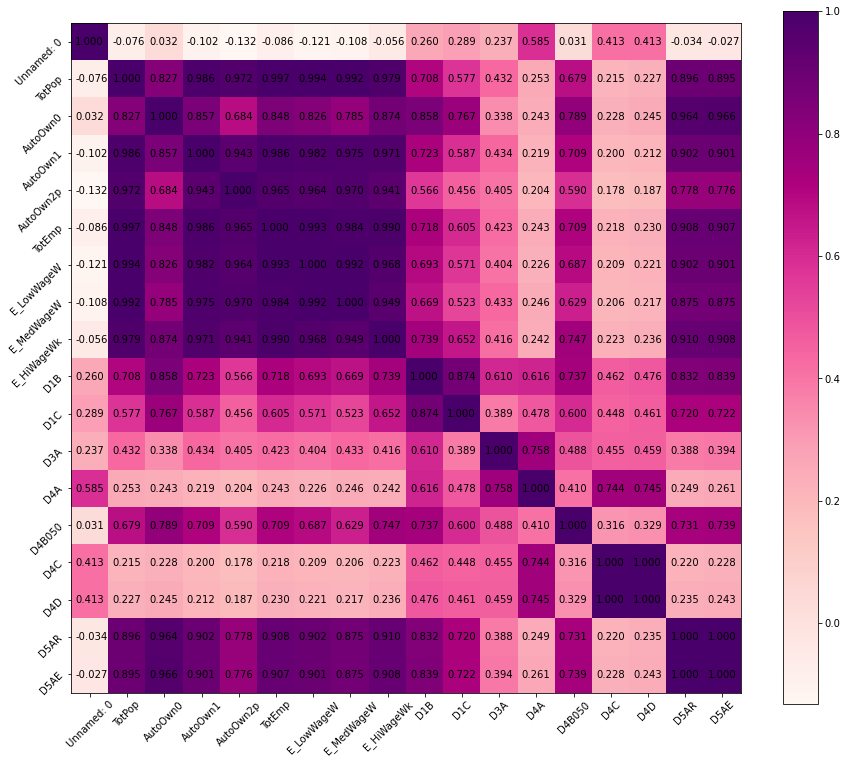

In [42]:
plt.figure(figsize=[15,15])
heat_plot_data_X = data_X.iloc[:, :18]
plt.imshow(heat_plot_data_X.corr(), cmap='RdPu')
for i in range(18):  # 18 features, number may subject to change
    for j in range(18):
        plt.text(i-0.4, j+0.1, '%.3f'%(heat_plot_data_X.corr().iloc[i, j]))
plt.xticks(range(18), list(heat_plot_data_X.columns), rotation = 45)
plt.yticks(range(18), list(heat_plot_data_X.columns), rotation = 45)
plt.colorbar(shrink=0.85)

(24, 24)


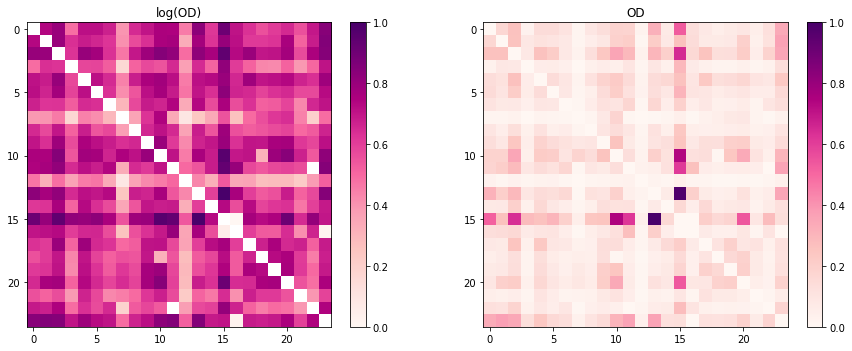

In [43]:
print(OD.shape)
fig = plt.figure(figsize=[15,7])

ax1 = fig.add_subplot(121)
ax1.imshow(np.log(OD), cmap='RdPu')
ax1.set_title('log(OD)')
fig.colorbar(cm.ScalarMappable(cmap='RdPu'), ax=ax1, shrink=0.8)

ax2 = fig.add_subplot(122)
ax2.imshow(OD, cmap='RdPu')
ax2.set_title('OD')
fig.colorbar(cm.ScalarMappable(cmap='RdPu'), ax=ax2, shrink=0.8)


# Prepare Feature Pairs
## For each OD pair in the OD matrix, it has its feature combination, [feature of loc1, feature of loc2, distance]

In [44]:
def GCDistance(S_Lat,S_Lon,E_Lat,E_Lon):
    start_lat = np.radians(S_Lat)  
    start_lon = np.radians(S_Lon)
    end_lat = np.radians(E_Lat)
    end_lon = np.radians(E_Lon)
    d_lat = end_lat - start_lat  
    d_lon = end_lon - start_lon  
    a = np.sin(d_lat/2)**2 + np.cos(start_lat) * np.cos(end_lat) * np.sin(d_lon/2)**2  
    c = 2 * np.arcsin(np.sqrt(a))  
    # Radius of earth is 3440 nm
    return 3440 * c

In [45]:
def get_data_X_OD(data_X):
    # preprocessing.StandardScaler(), see:
    # https://scikit-learn.org/stable/modules/preprocessing.html
    scalar = preprocessing.StandardScaler().fit(data_X.iloc[:, :18])
    data_X_norm = scalar.transform(data_X.iloc[:, :18])
    data_X.iloc[:, :18] = data_X_norm
    
    num_cities = CSA_df.shape[0]
    data_X_OD = np.zeros([num_cities*num_cities, 18*2+1])  # 18 features, may subject to change
    for i in range(CSA_df.shape[0]):
        org = CSA_df.loc[i, 'Airport']
        S_Lat = CSA_df.loc[i, 'lat']
        S_Lon = CSA_df.loc[i, 'lon']
        for j in range(CSA_df.shape[0]):
            dest = CSA_df.loc[i, 'Airport']
            feature_org = data_X.loc[data_X['CSA_Code']==org].values.flatten()[:18]
            feature_dest = data_X.loc[data_X['CSA_Code']==dest].values.flatten()[:18]
            feature = np.append(feature_org, feature_dest)
            
            E_Lat = CSA_df.loc[j, 'lat']
            E_Lon = CSA_df.loc[j, 'lon']
            distance = GCDistance(S_Lat,S_Lon,E_Lat,E_Lon)  # Great Circle Distance, unit: [nm]
            
            data_X_OD[i*num_cities+j, :] = np.append(feature, distance)
            
    return scalar, data_X_OD

In [46]:
scalar_data_X, data_X_OD = get_data_X_OD(data_X)  # shape: [num_cities * num_cities, num_features*2+1]
print('data_X_OD | Shape:', data_X_OD.shape, ', type: %s'%type(data_X_OD))
std_vec = data_X_OD.std(axis=0)
print('std_vec | Shape:', std_vec.shape, ', type: %s'%type(std_vec))
OD = np.array(OD).reshape(-1, 1)  # shape: [num_cities * num_cities, 1]
scalar_OD = preprocessing.StandardScaler().fit(OD)
OD = scalar_OD.transform(OD)
print('OD | Shape:', OD.shape, ', type: %s'%type(OD))

data_X_OD | Shape: (576, 37) , type: <class 'numpy.ndarray'>
std_vec | Shape: (37,) , type: <class 'numpy.ndarray'>
OD | Shape: (576, 1) , type: <class 'numpy.ndarray'>


# Define VAE Model Structure

In [47]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import TensorDataset

In [48]:
# Model specification
class VAE_FC_Net(nn.Module):
    def __init__(self, in_out_size, feature_dim=18+18+1, dropout_p=0.35):
        super(VAE_FC_Net, self).__init__()
        self.in_out_size = in_out_size
        self.feature_dim = feature_dim
        self.dropout_p = dropout_p
        
        self.encoder1 = nn.Sequential(
            nn.Linear(in_out_size, feature_dim),
            nn.ReLU(),
            nn.Dropout(dropout_p)
        )
        self.encoder2 = nn.Sequential(
            nn.Linear(in_out_size, feature_dim),
            nn.ReLU(),
            nn.Dropout(dropout_p)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(feature_dim, in_out_size),
            nn.ReLU(),
            nn.Dropout(dropout_p),
        )
        
        
    def forward(self, x):
        # shape of x: [batch, ]
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#         x = nn.BatchNorm1d(x.shape[1], device=device)(x)
        hidden_mean = self.encoder1(x)
#         hidden_out = nn.BatchNorm1d(hidden_out.shape[1], device=device)(hidden_out)
        # shape of "x" here = [batch, ]
        hidden_std = self.encoder2(x)
        
        # sampling process
        gaussian_noise = torch.normal(
            torch.normal(torch.zeros(self.feature_dim), torch.ones(self.feature_dim))
        ).view(-1, self.feature_dim)
        sampled_feature = hidden_mean + hidden_std*gaussian_noise
        
        y = self.decoder(sampled_feature)
        return hidden_mean, hidden_std, y

# Initialize the Model

In [49]:
# Train the model by inputing 
# flattened OD matrix
# to the model, then output the hidden feature and the reconstructed OD matrix
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE_FC_Net(in_out_size=1).to(device)
loss_recon = nn.MSELoss()  # reconstruction loss function

loss_set_train = []
loss_set_gen = []

print('There are %i OD pairs'%OD.shape[0])

There are 576 OD pairs


In [50]:
# summary(model) 

# Preparing data for PyTorch

In [51]:
OD = torch.tensor(OD, dtype=torch.float32).to(device)
data_X_OD = torch.tensor(data_X_OD, dtype=torch.float32).to(device)
std_vec = torch.tensor(std_vec, dtype=torch.float32)
std = std_vec.repeat([576, 1])

batch_size = 1024
loader_train = torch.utils.data.DataLoader(
    TensorDataset(OD, data_X_OD), batch_size, shuffle=False
)

iter_train = iter(loader_train)

# Train the Model

## Define KL Divergence between two Gaussian Distributions
<img src="./imgs/KL.png" width="500">

In [52]:
def KL_loss(mean1, std1, mean2, std2):
    # mean1, std1, mean2, std2 are 2-D matrices (type: tensor)
    # the first dimension is batch size, 
    # the second is number of variables
    
    # mean1, std1 are mean, std of predicted value
    # mean2, std2 are mean, std of true value
    # 1 and 2 are irreversible
    
    assert mean1.shape[0] == mean2.shape[0]
    assert mean1.shape[1] == mean2.shape[1]
    
    KL_div = torch.zeros(mean1.shape[0])

    for i in range(mean1.shape[0]):
        m1 = mean1[i, :]
        s1 = std1[i, :]
        m2 = mean2[i, :]
        s2 = std2[i, :]
        KL_div_i = -1/2 * torch.sum(
            torch.log(s1**2/s2**2) - s1**2/s2**2 - (m1-m2)**2/s2**2 + 1
        )
        KL_div[i] = KL_div_i
    return KL_div.mean()  # depends on the reconstruction loss reduction (either sum or mean)

In [53]:
optimizer = optim.Adam(model.parameters())

In [54]:
model.train()

epochs = 1000
   
for e in range(epochs):
    #ipdb.set_trace()
    for i in range(len(loader_train)):
        try:
            X, hid_mean = iter_train.next()
        except:
            iter_train = iter(loader_train)
            X, hid_mean = iter_train.next()

        hidden_mean, hidden_std, out = model(X)
        hidden_std[abs(hidden_std-0)<1e-8] = 1
        loss = loss_recon(out, X) + \
                    KL_loss(hidden_mean, hidden_std, hid_mean, std)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if e%50==0:

        out_gen = model.decoder(data_X_OD)
#         ipdb.set_trace()
        loss_gen = loss_recon(out_gen, X)

        loss_set_gen.append(loss_gen.cpu().detach().numpy())
        loss_set_train.append(loss.cpu().detach().numpy())

        # print the information of epoch e, the last mini-batch
        print('Epoch %i   success, val loss:%.6f, train loss:%.6f'%(
            e, loss_gen.cpu().detach().numpy(), loss.cpu().detach().numpy()
        ))
        

Epoch 0   success, val loss:1.015582, train loss:44.811852


KeyboardInterrupt: 

In [ ]:
model.decoder(data_X_OD)